# Mathematics Department RegEx Schedule Chatbot

## Importing Data from the Mathematics Department

In [1]:
import pandas as pd

data = pd.read_csv("scheds.csv")

In [2]:
data.head()

,first_name,last_name,Room,Section,Course,Day,Time
0,Edgar,Adina,W413,A37,DS195-1,Monday,10:30 AM - 12:00 PM
1,Edgar,Adina,W411,A37,DS168,Monday,4:30 PM - 6:00 PM
2,Edgar,Adina,S407,E01,CE50P-2,Tuesday,12:00 PM - 1:30 PM
3,Edgar,Adina,S407,E01,CE50P-2,Tuesday,1:30 PM - 3:00 PM
4,Edgar,Adina,SW400,A40,CEM118-2,Tuesday,3:00 PM - 4:30 PM


In [3]:
data["first_name"].unique()

array(['Edgar', 'Ronald', 'Juanito', 'Servando Jr.', 'Clarinda', 'Robert',
       'Richard', 'Maria Rosario', 'Reynaldo', 'Renilda',
       'Floro Deogracias', 'Francis Anthony', 'Dan Andrew', 'Agnes',
       'Ma. Vivianne', 'Joseph', 'Hardy', 'Raquel', 'Gerardo',
       'Maria Christina', 'Alberto', 'Teresita'], dtype=object)

## Detecting Parts of the Query
We will first find the following parts of the query:
- Professor's Name
- Section
- Course
- Time

In [4]:
import re

regex_hints = {
    "section": r"\b[A-ER][EFMNO]{0,2}[0-9]{1,2}\-?Q?",
    "course": r"[CDGMI][ACDEGHIMSTW]+[1-35]\d{0,2}[\-0-9CFLMP]*",
    "room": r"\b([EMNSW][BEMNOPSW]{0,2}[ 0-9]+[A-E]?)\b",
    "day": r"[F-Wf-w][A-Za-z]{2,}[Dd][Aa][Yy]"
}

In [5]:
def find_section(query):
    section_match = re.search(regex_hints["section"], query.upper())
    section_output = {}

    if section_match is None:
        section_output["section"] = None
    else:
        section_output["section"] = section_match.group(0)
    
    return section_output

find_section("A37")

{'section': 'A37'}

In [6]:
def find_course(query):
    course_match = re.search(regex_hints["course"], query.upper())
    course_output = {}

    if course_match is None:
        course_output["course"] = None
    else:
        course_output["course"] = course_match.group(0)
    
    return course_output

find_course("MATH147")

{'course': 'MATH147'}

In [7]:
lower_prof_fns_raw = [ last_name.lower() for last_name in data["first_name"].unique() ]
# Separate first names of profs if profs have multiple first names
lower_prof_fns_raw = [ first_name.split() for first_name in lower_prof_fns_raw ]
lower_prof_fns = []

for fns_raw in lower_prof_fns_raw:
    for name in fns_raw:
        lower_prof_fns.append(name)

lower_prof_lns = [ last_name.lower() for last_name in data["last_name"].unique() ]

def find_prof(query):
    lower_query = query.lower()
    prof_output = { "professor": None }

    found_last_name = [ lower_prof_ln for lower_prof_ln in lower_prof_lns if lower_query.find(lower_prof_ln) > -1 ]
    if len(found_last_name) > 0:
        prof_output["professor"] = { "last_name": found_last_name }
    
    found_first_name = [ lower_prof_fn for lower_prof_fn in lower_prof_fns if lower_query.find(lower_prof_fn) > -1 ]
    if len(found_first_name) > 0:
        prof_output["professor"] = { "first_name": found_first_name }

    return prof_output

find_prof("francis")

{'professor': {'first_name': ['francis']}}

In [8]:
def find_room(query):
    room_match = re.search(regex_hints["room"], query.upper())
    room_output = {}

    if room_match is None:
        room_output["room"] = None
    else:
        room_output["room"] = room_match.group(0)
        if len(room_output["room"]) < 3:
            room_output["room"] = None
    
    return room_output

find_room("S309")

{'room': 'S309'}

In [9]:
from datetime import datetime

def find_day(query):
    day_output = { "day": None }
    
    day_match = re.search(regex_hints["day"], query)
    if day_match is not None:
        day_output["day"] = day_match.group(0).upper()[0:1] + day_match.group(0).lower()[1:]
    
    today_match = re.search("(?i)today", query)
    if today_match is not None:
        dt = datetime.now()
        days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        day_output["day"] = days_of_the_week[dt.weekday()]

    return day_output

find_day("Wednesdays")

{'day': 'Wednesday'}

## Making the ChatBot Class

In [10]:
def write_profs(in_data):
    if len(in_data) == 0: return ""
    
    full_names_col = in_data["first_name"] + ' ' + in_data["last_name"]
    full_names = full_names_col.unique()
    
    output_str = full_names[0]

    if len(full_names) == 1:
        return output_str
    if len(full_names) == 2:
        output_str += " and " + full_names[1]
        return output_str
    else:
        for i in range(1, len(full_names) - 1):
            output_str += ", " + full_names[i]
        output_str += ", and " + full_names[len(full_names) - 1]
        return output_str

In [11]:
def write_stuff(in_stuff):
    if len(in_stuff) == 0: return ""

    output_str = in_stuff[0]
    
    if len(in_stuff) == 1:
        return output_str
    if len(in_stuff) == 2:
        output_str += " and " + in_stuff[1]
        return output_str
    else:
        for i in range(1, len(in_stuff) - 1):
            output_str += ", " + in_stuff[i]
        output_str += ", and " + in_stuff[len(in_stuff) - 1]
        return output_str

In [12]:
class ChatBot:
    def __init__(self):
        self.memory = {}
    
    def ask(self, query):
        self_memory_copy = dict(self.memory)
        self.memory = {}
        self.memory = { k:v for d in (
            find_section(query),
            find_course(query),
            find_prof(query),
            find_room(query),
            find_day(query)
        ) for k,v in d.items() }

        # Remembering information from old queries
        for key in self_memory_copy.keys():
            if self.memory[key] is None:
                self.memory[key] = self_memory_copy[key]
        
        before_wipe_keys = self.memory.keys()
        before_wipe_vals = self.memory.values()
        vals_enumerate = enumerate(before_wipe_vals)
        non_empty_indices = [ enum[0] for enum in vals_enumerate if enum[1] is not None ]

        self.memory = { k: v for k, v in self.memory.items() if v is not None }
        memory_keys = self.memory.keys()
        memory_vals = self.memory.values()
        
        # Checking if data is sufficient
        if "professor" in memory_keys:
            pass
        elif "course" in memory_keys:
            pass
        else:
            sched_res_copy = data[data["last_name"] == "non-existent prof"]  
            custom_response = self.get_response(query, sched_res_copy)
            print(custom_response)
            return {
                "message": custom_response if custom_response is not None else "Please specify a professor or course.",
                "result": None
            }

        # Filtereing data based on query
        sched_res = data
        if "professor" in self.memory.keys():
            sched_res_copy = data[data["last_name"] == "non-existent prof"]            
            
            if "last_name" in self.memory["professor"].keys():
                for ln in self.memory["professor"]["last_name"]:
                    sched_res_copy = pd.concat([sched_res_copy, sched_res[sched_res["last_name"].str.contains("(?i)" + ln)]])
            
            if "first_name" in self.memory["professor"].keys():
                for fn in self.memory["professor"]["first_name"]:
                    sched_res_copy = pd.concat([sched_res_copy, sched_res[sched_res["first_name"].str.contains("(?i)" + fn)]])
            sched_res = sched_res_copy.drop_duplicates()
        
        if "course" in self.memory.keys():
            sched_res = sched_res[sched_res["Course"].str.contains(self.memory["course"].upper())]
            
        if "section" in self.memory.keys():
            sched_res = sched_res[sched_res["Section"].str.contains(self.memory["section"].upper())]
        
        if "room" in self.memory.keys():
            sched_res = sched_res[sched_res["Room"].str.contains(self.memory["room"].upper())]

        if "day" in self.memory.keys():
            sched_res = sched_res[sched_res["Day"].str.contains(self.memory["day"])]

        # Clearing memory
        self.memory = {}
        
        get_res_result = self.get_response(query, sched_res)
        return {
            "message": get_res_result,
            "result": sched_res
        }
    
    def message_probability(self, user_message, recognised_words, single_response=False, required_words=[]):
        message_certainty = 0
        has_required_words = True

        # Counts how many words are present in each predefined message
        for word in user_message:
            if word in recognised_words:
                message_certainty += 1

        # Calculates the percent of recognised words in a user message
        percentage = float(message_certainty) / float(len(recognised_words))

        # Checks that the required words are in the string
        for word in required_words:
            if word not in user_message:
                has_required_words = False
                break

        # Must either have the required words, or be a single response
        if has_required_words or single_response:
            return int(percentage * 100)
        else:
            return 0
    
    def check_all_messages(self, message, sched):
        highest_prob_list = {}

        def response(bot_response, list_of_words, single_response=False, required_words=[]):
            nonlocal highest_prob_list
            highest_prob_list[bot_response] = self.message_probability(message, list_of_words, single_response, required_words)

        # Responses -------------------------------------------------------------------------------------------------------
        response(write_profs(sched), ['who'], required_words=['who'])
        response(write_stuff(sched['Day'].unique()), ['when','does'], required_words=['when'])
        response(write_stuff(sched['Course'].unique()), ['what','course','does'], required_words=['what','course'])
        response(write_stuff(sched['Time'].unique()), ['what','time','does'], required_words=['what','time'])
        response(write_stuff(sched['Room'].unique()), ['where','does'], required_words=['where'])
        response('Hello',['hi','how are you?','wassup','hello'],single_response=True)
        # response('You\'re welcome!', ['thank', 'thanks'], single_response=True)


        best_match = max(highest_prob_list, key=highest_prob_list.get)
        # print(highest_prob_list)
        # print(f'Best match = {best_match} | Score: {highest_prob_list[best_match]}')
        # return best_match
        return None if highest_prob_list[best_match] < 1 else best_match

    def get_response(self, user_input, sched):
        split_message = re.split(r'\s+|[,;?!.-]\s*', user_input.lower())
        response = self.check_all_messages(split_message, sched)
        return response

In [13]:
chatbot = ChatBot()

sched = None
while sched is None:
    chatbot_query = input("Write what you want to say to the chatbot: ")
    sched = chatbot.ask(chatbot_query)  
# [ str(val) for val in sched.values ]
# chatbot.get_response(chatbot_query)
sched

Write what you want to say to the chatbot: What is sir adina's schedule for monday?
   first_name last_name   Room Section    Course        Day  \
0       Edgar     Adina   W413     A37   DS195-1     Monday   
1       Edgar     Adina   W411     A37     DS168     Monday   
2       Edgar     Adina   S407     E01   CE50P-2    Tuesday   
3       Edgar     Adina   S407     E01   CE50P-2    Tuesday   
4       Edgar     Adina  SW400     A40  CEM118-2    Tuesday   
5       Edgar     Adina  SW400     A40  CEM118-2    Tuesday   
6       Edgar     Adina  SW400     A40  CEM118-2    Tuesday   
7       Edgar     Adina   W413     A37   DS195-1  Wednesday   
8       Edgar     Adina   W411     A37     DS168  Wednesday   
9       Edgar     Adina   S103     E01   CE50P-2   Thursday   
10      Edgar     Adina   S103     E01   CE50P-2   Thursday   
11      Edgar     Adina   S103     E01   CE50P-2   Thursday   
12      Edgar     Adina    FLD     A37  DS200-1L   Thursday   
13      Edgar     Adina    FLD    

,first_name,last_name,Room,Section,Course,Day,Time
0,Edgar,Adina,W413,A37,DS195-1,Monday,10:30 AM - 12:00 PM
1,Edgar,Adina,W411,A37,DS168,Monday,4:30 PM - 6:00 PM


Schedule generated.


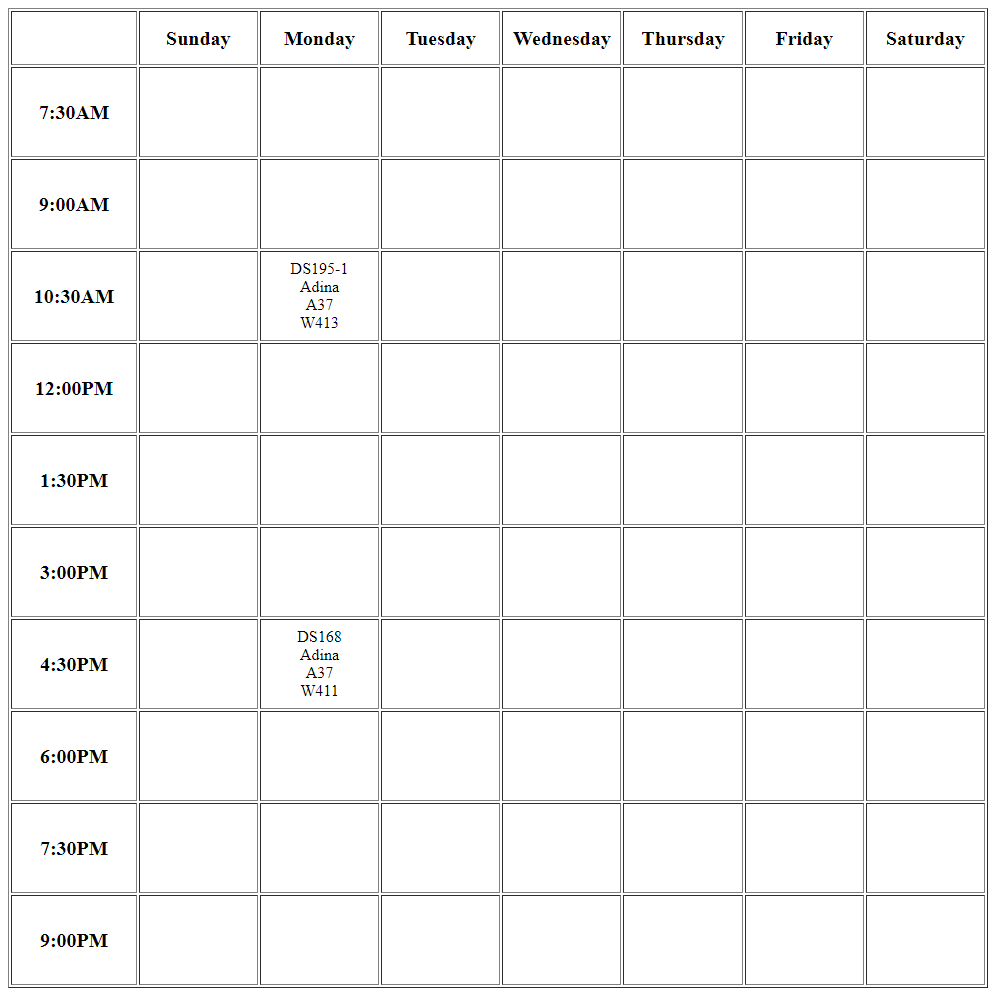

In [14]:
from bs4 import BeautifulSoup

days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
days_id_part = ["sun", "mon", "tue", "wed", "thu", "fri", "sat"]

times = ['7:30 AM - 9:00 AM', '9:00 AM - 10:30 AM', '10:30 AM - 12:00 PM',
         '12:00 PM - 1:30 PM', '1:30 PM - 3:00 PM', '3:00 PM - 4:30 PM', 
         '4:30 PM - 6:00 PM', '6:00 PM - 7:30 PM', '7:30 PM - 9:00 PM']
times_id_part = ["7-30am", "9-00am", "10-30am", "12-00pm", "1-30pm",
                 "3-00pm", "4-30pm", "6-00pm", "7-30pm"]

fp = open("template.html")
soup = BeautifulSoup(fp, "html.parser")
fp.close()
# print(soup)

for i in range(len(sched)):
    row_vals = sched.iloc[i,].values
    ln = row_vals[1]
    room = row_vals[2]
    section = row_vals[3]
    course = row_vals[4]
    day = row_vals[5]
    time = row_vals[6]

    td_prefix = days_id_part[days.index(day)]
    td_suffix = times_id_part[times.index(time)]
    td_id = td_prefix + '-' + td_suffix
    
    if len(soup.find(id = td_id).contents) < 1:
        schedule_html = '<p>' + course + '</p><p>' + ln + '</p><p>' + section + '</p><p>' + room + '</p>'
        schedule_element = BeautifulSoup(schedule_html)
        # soup.find(id = td_id).clear()
        soup.find(id = td_id).append(schedule_element)
    else:
        soup.find(id = td_id)['style'] = "background-color: orange; color: white;"

html_code_txt = open("template_filled.html", "w")
html_code_txt.write(str(soup))
html_code_txt.close()

!python make_img.py
from IPython.display import Image
Image(filename='sched_output.png') 